In [1]:
from qutip import *
import numpy as np

In [2]:
# Defining the system Hamiltonian
eps = 0.2    # Energy of the 2-level system.
Del = 0   # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()
tlist=np.linspace(0,10,1000)

## Spectral density fitting

In [24]:
w = np.linspace(0, 20, 20000)
def ohmic_spectral_density(w, alpha, wc):
    """ The Ohmic bath spectral density as a function of w
        (and the bath parameters).
    """
    return w * alpha * np.e**(-w / wc)

In [25]:
alpha=0.05
T=1
wc=0.5

In [26]:
J=ohmic_spectral_density(w,alpha,wc)

In [27]:
obp=heom.FitSpectral(T, sigmax(), Nk=4)

In [28]:
obp.get_fit(J,w,final_rmse=9e-6)

In [29]:
options = {'nsteps':15000, 'store_states':True, 'rtol':1e-12, 'atol':1e-12, 'method':"bdf"}
HEOM_spectral_fit = heom.HEOMSolver(Hsys, obp.Bath_spec, max_depth=4, options=options,)
result_spectral=HEOM_spectral_fit.run(rho0,tlist)

10.0%. Run time:   0.13s. Est. time left: 00:00:00:01
20.0%. Run time:   0.21s. Est. time left: 00:00:00:00
30.0%. Run time:   0.29s. Est. time left: 00:00:00:00
40.0%. Run time:   0.35s. Est. time left: 00:00:00:00
50.1%. Run time:   0.43s. Est. time left: 00:00:00:00
60.1%. Run time:   0.50s. Est. time left: 00:00:00:00
70.1%. Run time:   0.57s. Est. time left: 00:00:00:00
80.1%. Run time:   0.65s. Est. time left: 00:00:00:00
90.1%. Run time:   0.73s. Est. time left: 00:00:00:00
100.0%. Run time:   0.81s. Est. time left: 00:00:00:00
Total run time:   0.81s


In [30]:
obp.summary()

Results of the fitting the Spectral density with 4 terms: 
 
 Parameters|   lam    |  gamma   |   w0 
 1         | 7.67e-02 | 3.21e-01 |5.00e-02 
 2         |-8.19e-03 | 2.15e+00 |2.04e+00 
 3         |-7.58e-02 | 3.20e-01 |5.31e-02 
 4         | 1.52e-02 | 1.13e+00 |5.01e-02 
 
A  normalized RMSE of  2.28e-06 was obtained for the Spectral density 
 The current fit took  25.667022 seconds


## Correlation Function Fitting

In [31]:
from mpmath import mp
alpha=0.05
T=1
wc=0.5

In [32]:
def ohmic_correlation(t, alpha, wc, beta, s=1):
    """ The Ohmic bath correlation function as a function of t
        (and the bath parameters).
    """
    corr = (
        (1 / np.pi) * alpha * wc**(1 - s) * beta**(-(s + 1)) * mp.gamma(s + 1)
    )
    z1_u = (1 + beta * wc - 1.0j * wc * t) / (beta * wc)
    z2_u = (1 + 1.0j * wc * t) / (beta * wc)
    # Note: the arguments to zeta should be in as high precision as possible.
    # See http://mpmath.org/doc/current/basics.html#providing-correct-input
    return np.array([
        complex(corr * (mp.zeta(s + 1, u1) + mp.zeta(s + 1, u2)))
        for u1, u2 in zip(z1_u, z2_u)
    ], dtype=np.complex128)

In [33]:
C=ohmic_correlation(tlist,alpha,wc,1/T)

In [34]:
obp2=heom.FitCorr(sigmax())

In [35]:
obp2.fit_correlation(tlist,C,final_rmse=8e-5)

In [36]:
obp2.summary()

Fit correlation class instance: 
 

Results of the fitting the Real Part with 3 terms:                |	 Results of the fitting the Imaginary Part with 4 terms:             
                                                                  |                                                                      
 Parameters|   lam    |  gamma   |   w0                           | 	 Parameters|   lam    |  gamma   |   w0                             
 1         | 3.54e-03 |-1.81e-01 |3.78e-14                        |	 1         |-1.29e-02 |-8.57e-01 |3.44e-01                           
 2         |-6.46e-03 |-2.07e+00 |1.28e+00                        | 	 2         | 1.17e-03 |-2.15e+00 |2.33e+00                          
 3         | 1.95e-02 |-6.56e-01 |8.73e-11                        | 	 3         |-1.89e-03 |-1.01e+00 |1.04e+00                          
                                                                  | 	 4         |-1.29e-02 |-3.93e-01 |2.36e-02                         

In [37]:
options = {'nsteps':15000, 'store_states':True, 'rtol':1e-12, 'atol':1e-12, 'method':"bdf"}
HEOM_corr_fit = heom.HEOMSolver(Hsys, obp2.Bath_corr, max_depth=4, options=options,)
result_corr=HEOM_corr_fit.run(rho0,tlist)

10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.10s. Est. time left: 00:00:00:00
30.0%. Run time:   0.13s. Est. time left: 00:00:00:00
40.0%. Run time:   0.17s. Est. time left: 00:00:00:00
50.1%. Run time:   0.20s. Est. time left: 00:00:00:00
60.1%. Run time:   0.23s. Est. time left: 00:00:00:00
70.1%. Run time:   0.26s. Est. time left: 00:00:00:00
80.1%. Run time:   0.29s. Est. time left: 00:00:00:00
90.1%. Run time:   0.33s. Est. time left: 00:00:00:00
100.0%. Run time:   0.35s. Est. time left: 00:00:00:00
Total run time:   0.35s


# Comparison between fits

In [38]:
def projection(result,i,j):
    return [result.states[k][i,j] for k in range(len(result.states))]

In [39]:
import matplotlib.pyplot as plt

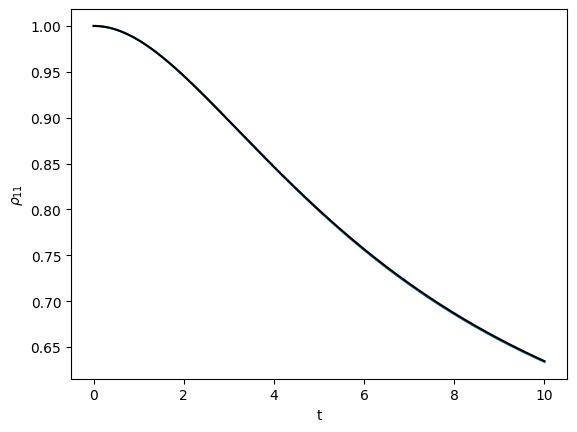

In [40]:
plt.plot(tlist,projection(result_corr,0,0))
plt.plot(tlist,projection(result_spectral,0,0),color='k')
plt.xlabel('t')
plt.ylabel(r'$\rho_{11}$')
plt.show()

In [41]:
def ohmic_power_spectrum(w, alpha, wc, beta):
    """ The Ohmic bath power spectrum as a function of w
        (and the bath parameters).
    """
    return (
        w * alpha * np.e**(-abs(w) / wc) *
        ((1 / (np.e**(w * beta) - 1)) + 1) * 2
    )

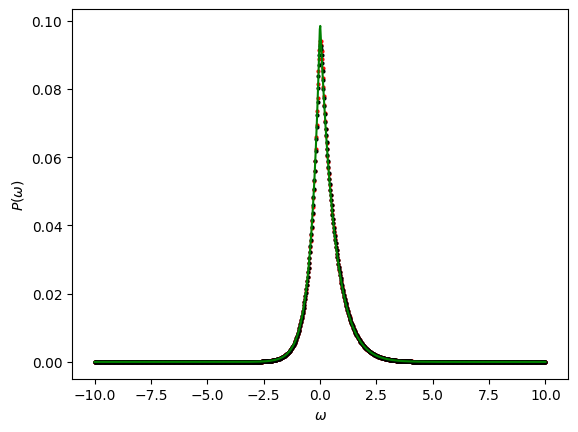

In [54]:
w=np.linspace(-10,10,1000)
plt.plot(w,ohmic_power_spectrum(w,alpha,wc,1/T),color='green')
plt.scatter(w,obp2.corr_spectrum_approx(w),color='red',s=4)
plt.scatter(w,obp.spec_spectrum_approx(w),color='k',s=4)
plt.ylabel(r'$P( \omega )$')
plt.xlabel(r'$\omega$')
plt.show()